# Stage 3 - Aiming Perfection With Deep Learning 
### For Stage 3 of the project, even though we've achieved near-perfect results with traditional machine learning algorithms, we aim to attain absolute perfection by harnessing neural networks. This will enable us to explore more complex architectures like fully connected networks (MLPs), pushing the boundaries of performance to achieve even higher precision and recall in fraud detection.

# 0. Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, make_scorer, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
import optuna
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import backend as K
import seaborn as sns

c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Useful steps from stage 1

In [2]:
cleaned_data = pd.read_csv('cleaned_data.csv', sep=',')
cleaned_data.head()

X = cleaned_data.drop(columns=['fraud'])
y = cleaned_data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # we only transform the test data, we do not fit the scaler again to avoid data leakage.


f2_scorer = make_scorer(fbeta_score, beta=2)

We do not use SMOTE with neural networks because it can lead to overfitting by introducing synthetic examples that add noise and redundancy, which affects the model's ability to generalize effectively. Neural networks models already have a great learning ability.

In [3]:
# Création du modèle ANN
model_ann = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
from tqdm import tqdm
import optuna
import tensorflow as tf
from tensorflow.keras import layers

# Fonction d'objectif pour Optuna
def objective(trial):
    # Optimisation dynamique du nombre de couches
    num_layers = trial.suggest_int('num_layers', 2, 5)  # Nombre de couches cachées : de 2 à 5

    # Hyperparamètres pour chaque couche
    hidden_units = [trial.suggest_int(f'num_units_layer{i}', 64, 512, step=32) for i in range(num_layers)]
    dropout_rates = [trial.suggest_float(f'dropout_rate_layer{i}', 0.2, 0.5, step=0.1) for i in range(num_layers)]
    use_batchnorm = [trial.suggest_categorical(f'use_batchnorm_layer{i}', [True, False]) for i in range(num_layers)]

    # Autres hyperparamètres
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])

    # Création du modèle ANN dynamique
    model = tf.keras.Sequential()
    model.add(layers.Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1],)))
    if use_batchnorm[0]:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rates[0]))

    for i in range(1, num_layers):
        model.add(layers.Dense(hidden_units[i], activation='relu'))
        if use_batchnorm[i]:
            model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rates[i]))

    # Couche de sortie
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilation du modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['recall']  # Maximiser le rappel
    )

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stopping]
    )

    # Evaluation sur le set de validation
    val_loss, val_recall = model.evaluate(X_test, y_test, verbose=0)
    return val_recall  # Maximiser le rappel

# Nombre d'itérations pour Optuna
n_trials = 100

# Initialisation de tqdm
with tqdm(total=n_trials, desc="Optimisation des hyperparamètres") as pbar:
    def objective_with_progress(trial):
        # Appeler l'objectif d'origine
        result = objective(trial)

        # Mise à jour de la barre de progression
        pbar.update(1)
        pbar.set_postfix({'val_recall': result})
        return result

    # Étude Optuna avec tqdm
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_with_progress, n_trials=n_trials)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study.best_params)

# Réentraîner le modèle avec les meilleurs hyperparamètres
best_params = study.best_params
num_layers = best_params['num_layers']

model_ann = tf.keras.Sequential()
model_ann.add(layers.Dense(best_params[f'num_units_layer0'], activation='relu', input_shape=(X_train.shape[1],)))
if best_params[f'use_batchnorm_layer0']:
    model_ann.add(layers.BatchNormalization())
model_ann.add(layers.Dropout(best_params[f'dropout_rate_layer0']))

for i in range(1, num_layers):
    model_ann.add(layers.Dense(best_params[f'num_units_layer{i}'], activation='relu'))
    if best_params[f'use_batchnorm_layer{i}']:
        model_ann.add(layers.BatchNormalization())
    model_ann.add(layers.Dropout(best_params[f'dropout_rate_layer{i}']))

model_ann.add(layers.Dense(1, activation='sigmoid'))

model_ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['recall']
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraînement final
history = model_ann.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping]
)


Optimisation des hyperparamètres:   0%|          | 0/100 [00:00<?, ?it/s][I 2024-12-04 19:41:55,593] A new study created in memory with name: no-name-c1c54e8e-c3c0-421e-9038-8d8c38c97f40
C:\Users\delah\AppData\Local\Temp\ipykernel_19568\2103049184.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
Optimisation des hyperparamètres:   1%|          | 1/100 [03:32<5:49:56, 212.09s/it, val_recall=0.977][I 2024-12-04 19:45:27,686] Trial 0 finished with value: 0.9772323966026306 and parameters: {'num_layers': 5, 'num_units_layer0': 96, 'num_units_layer1': 64, 'num_units_layer2': 128, 'num_units_layer3': 160, 'num_units_layer4': 128, 'dropout_rate_layer0': 0.30000000000000004, 'dropout_rate_layer1': 0.5, 'dropout_rate_layer2': 0.2, 'dropout_rate_layer3': 0.2, 'drop

Meilleurs hyperparamètres : {'num_layers': 2, 'num_units_layer0': 96, 'num_units_layer1': 384, 'dropout_rate_layer0': 0.2, 'dropout_rate_layer1': 0.5, 'use_batchnorm_layer0': False, 'use_batchnorm_layer1': False, 'learning_rate': 0.0001888927584075318, 'batch_size': 512}
Epoch 1/50



c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6254 - recall: 0.2807 - val_loss: 0.1458 - val_recall: 0.7065
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1485 - recall: 0.6027 - val_loss: 0.0758 - val_recall: 0.7478
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0908 - recall: 0.7277 - val_loss: 0.0597 - val_recall: 0.8260
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0704 - recall: 0.7767 - val_loss: 0.0468 - val_recall: 0.8611
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0565 - recall: 0.8328 - val_loss: 0.0357 - val_recall: 0.8645
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0450 - recall: 0.8772 - val_loss: 0.0266 - val_recall: 0.9366
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0362 - recall: 0.9090 - val_loss: 0.0216 - val_recall: 0.9399
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0306 - recall: 0.9274 - val_loss: 0.0182 - val_recall: 0.9434
Epo

In [5]:
# Réentraîner le modèle avec les meilleurs hyperparamètres
best_params = study.best_params
model_ann = tf.keras.Sequential([
    layers.Dense(best_params['num_units_layer1'], activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(best_params['dropout_rate1']),
    layers.Dense(best_params['num_units_layer2'], activation='relu'),
    layers.Dropout(best_params['dropout_rate2']),
    layers.Dense(best_params['num_units_layer3'], activation='relu'),
    layers.Dropout(best_params['dropout_rate3']),
    layers.Dense(1, activation='sigmoid')
])

model_ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['recall']
)

# Early stopping pour le réentraînement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraînement final
history = model_ann.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping]
)

c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyError: 'dropout_rate1'

In [10]:
# Prédictions
y_pred_ann = (model_ann.predict(X_test) > 0.5).astype(int)

# Évaluation
print("Réseau de Neurones :")
print(classification_report(y_test, y_pred_ann))
print(confusion_matrix(y_test, y_pred_ann))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 587us/step
Réseau de Neurones :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000

[[182370    149]
 [   155  17326]]


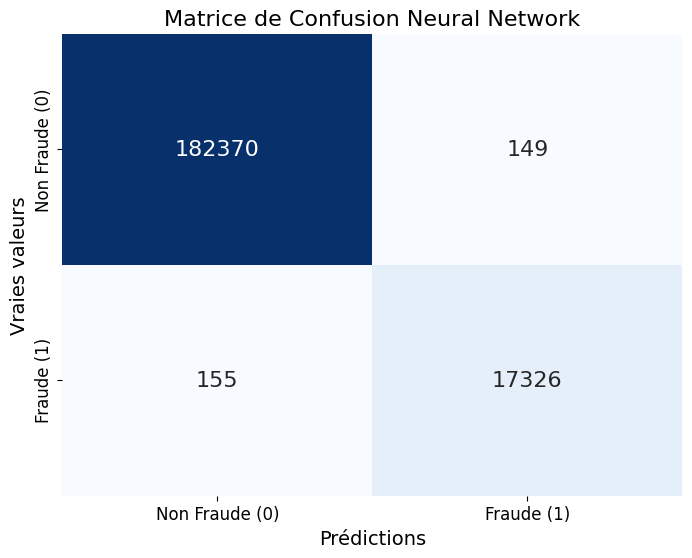

In [11]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_ann)

# Création du graphique
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

# Ajout des labels et du titre
plt.xlabel('Prédictions', fontsize=14)
plt.ylabel('Vraies valeurs', fontsize=14)
plt.title('Matrice de Confusion Neural Network', fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=['Non Fraude (0)', 'Fraude (1)'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['Non Fraude (0)', 'Fraude (1)'], fontsize=12)

# Afficher le graphique
plt.show()

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 606us/step
AUC-ROC pour le réseau de neurones : 1.0000


C:\Users\delah\AppData\Local\Temp\ipykernel_19568\3866738057.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)', color='red')


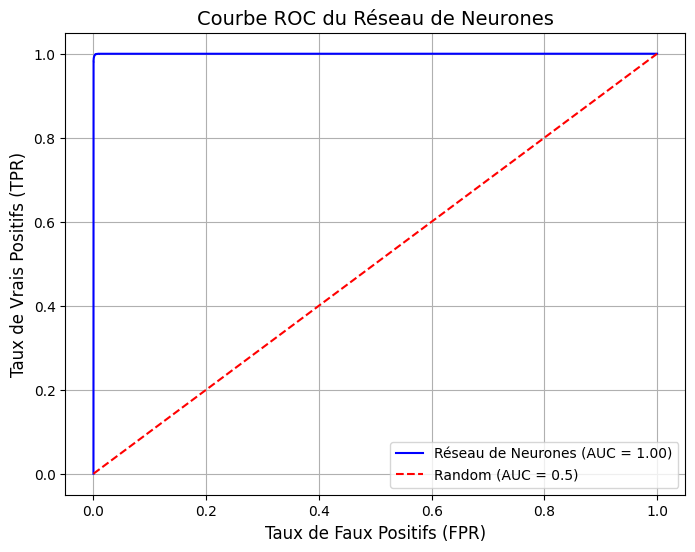

In [12]:
# Obtenir les probabilités pour la classe positive (fraude)
y_proba_ann = model_ann.predict(X_test).flatten()  # Utiliser predict() pour obtenir les probabilités

# Calcul du score AUC-ROC
auc_ann = roc_auc_score(y_test, y_proba_ann)
print(f"AUC-ROC pour le réseau de neurones : {auc_ann:.4f}")

# Calcul des courbes ROC
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_proba_ann)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f"Réseau de Neurones (AUC = {auc_ann:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)', color='red')

# Personnalisation du graphique
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC du Réseau de Neurones', fontsize=14)
plt.legend(loc='lower right')
plt.grid()
plt.show()

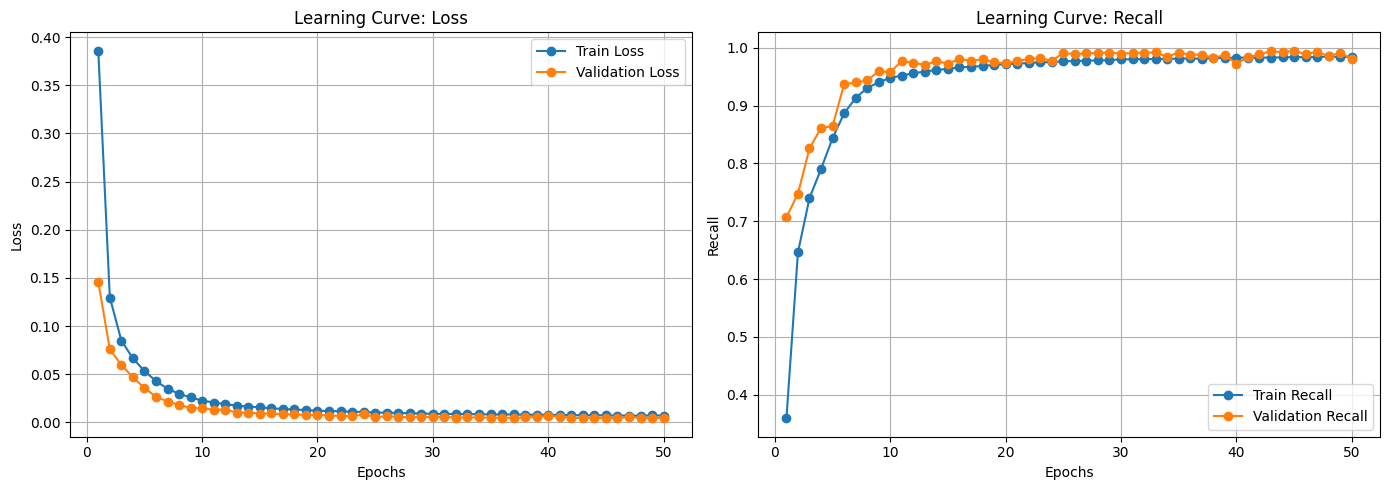

In [13]:
# Fonction pour afficher la Learning Curve
def plot_learning_curve(history):
    """
    Affiche les courbes de la perte et des métriques au cours des époques d'entraînement.
    
    Parameters:
    - history: l'historique retourné par model.fit()
    """
    # Récupérer les données de l'historique
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(loss) + 1)
    
    # Tracer la courbe de la perte
    plt.figure(figsize=(14, 5))
    
    # Perte
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Learning Curve: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    # Rappel
    plt.subplot(1, 2, 2)
    plt.plot(epochs, recall, label='Train Recall', marker='o')
    plt.plot(epochs, val_recall, label='Validation Recall', marker='o')
    plt.title('Learning Curve: Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction avec l'historique du modèle
plot_learning_curve(history)